<a href="https://colab.research.google.com/github/toussaintma/neuralnetworksfromzerotohero/blob/main/walkthrough_makemore_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# data and code at https://github.com/karpathy/makemore
# course at https://www.youtube.com/watch?v=PaCmpygFfXo&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=2&t=11s
# Bengio 2003 paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

In [5]:
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
df_words = pd.read_csv('names.txt', header=None, names=['name'])
df_words.shape

(32033, 1)

In [7]:
words = df_words['name'].values.tolist()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [8]:
chars = sorted(list(set("".join(words))))
stoi = {c : i + 1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i + 1: chars[i] for i in range(len(chars))}
itos[0] = '.'

In [42]:
block_size = 3
X = []
Y = []
for w in words[:5]:
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), ' --> ', itos[ix])
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [178]:
block_size = 5
emb_size = 15
inner_size = 300

In [179]:
def build_dataset(word):
  X = []
  Y = []
  for w in words[:]:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), ' --> ', itos[ix])
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


In [180]:
C = torch.randn((27, emb_size))

In [68]:
#C[5], F.one_hot(torch.tensor(5), num_classes = 27).float() @ C

(tensor([-0.2427, -0.5470,  0.0335,  1.0634, -2.3429, -0.9825, -0.2980,  0.2960,
          1.2539,  0.1154]),
 tensor([-0.2427, -0.5470,  0.0335,  1.0634, -2.3429, -0.9825, -0.2980,  0.2960,
          1.2539,  0.1154]))

In [181]:
emb = C[Xtr]
#emb.view(32, 6) == torch.cat(torch.unbind(emb, dim=1), dim=1)
emb.shape

torch.Size([228146, 5, 15])

In [182]:
W1 = torch.randn((block_size * emb_size, inner_size))
b1 = torch.randn(inner_size)
W2 = torch.randn((inner_size, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True
sum(p.nelement() for p in parameters)


31332

In [183]:
#lre = torch.linspace(-3, 0, 1000)
#lrs = 10**lre
lossi = []
stepi = []
#lri = []

In [189]:
for i in range(50000):
  # mini batch
  ix = torch.randint(0, Xtr.shape[0], (64,))

  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(emb.shape[0], block_size * emb_size) @ W1 + b1) # emb.shape[0], block_size * emb_size
  logits = h @ W2 + b2
  #counts = logits.exp()
  #prob = counts / counts.sum(dim=1, keepdim=True)
  #loss = -prob[torch.arange(32), Y].log().mean()
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1
  for p in parameters:
    p.data -= lr * p.grad

  # stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())
print(loss.item())
#plt.plot(lri, lossi)

2.614713668823242


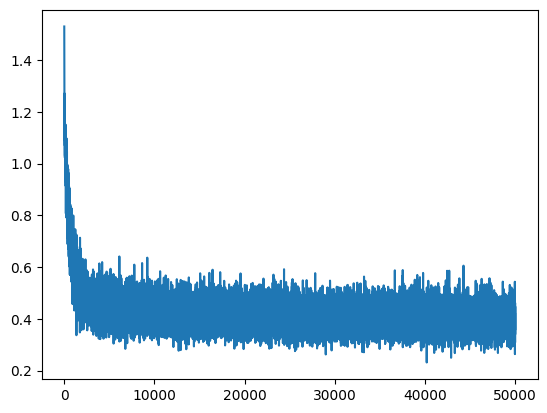

In [185]:
plt.plot(stepi, lossi)

In [190]:
emb = C[Xdev]
h = torch.tanh(emb.view(emb.shape[0], block_size * emb_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2637, grad_fn=<NllLossBackward0>)

In [116]:
def sampling():
  output = []
  context = [0] * block_size
  sample = 0

  while True:
    emb = C[torch.tensor(context)] # 1, 3, 10
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, 1).item()
    context = context[1:] + [ix]
    output.append(ix)
    if ix == 0:
      break
  return output


In [191]:
for n in range(20):
  r = sampling()
  result = ''
  for i in r:
    result += itos[i]
  print(result)

chace.
rar.
laanna.
caskleenari.
rucsh.
rashdonbrexson.
carsland.
rotlizandrea.
sasho.
hhben.
asihfer.
crehce.
sakina.
costelynn.
jahphandonily.
ormisne.
chrreka.
camwannira.
corlenn.
beronia.


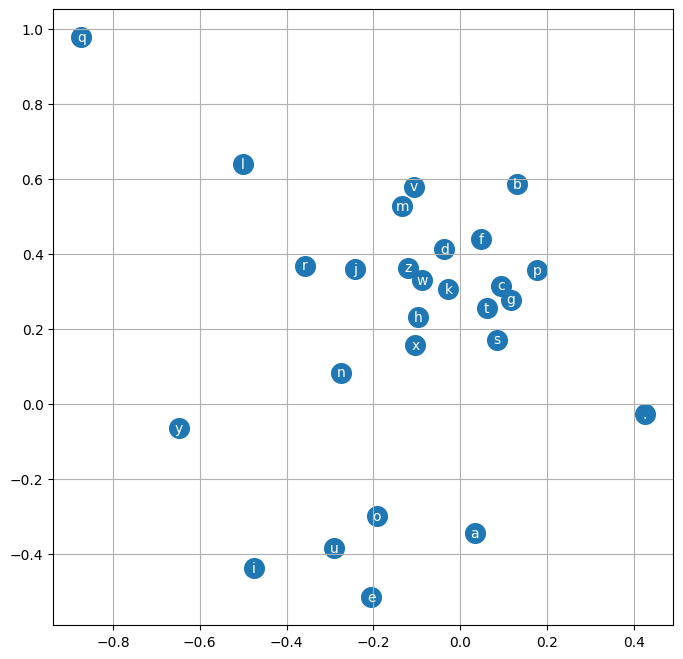

In [65]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')